# OpenCV Reflective Tape Detection

In [1]:
# import stuff we need
%matplotlib inline

import matplotlib.pyplot as plt
import cv2

## 1. Load the image

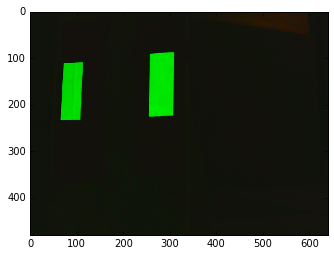

In [2]:
img = cv2.imread("img/vision_tape_2017.png", cv2.IMREAD_COLOR)

# opencv loads color images in BGR, but matplot wants RGB
# so we need to convert between the two color spaces.
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## 2. Convert to HSV

HSV (hue, saturation, value) is an alternate color space which is often easier to work with than RGB (red, green, blue). HSV represents colors by their angle around the color wheel (hue), how saturated the color is, and how dark the color is (value).

In [3]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

## 3. Threshold

Use `cv2.inRange` to threshold the HSV image. Pixels that fall between the two supplied HSV colors will become white and everything else will become black.

Finding the right lower and upper bounds takes some experimenting and is somewhat specific to the camera and lighting you're using. In this example, we use the color range $\text{HSV}(110^{\circ}, 90\%, 78\%)$ to $\text{HSV}(130^{\circ}, 100\%, 100\%)$.

**Important:** In OpenCV, hue ranges from 0 to 180 so you need to **halve** the actual angle around the color wheel. Additionally, OpenCV uses saturation/value in the range 0 to 255, so you need to convert percentages.

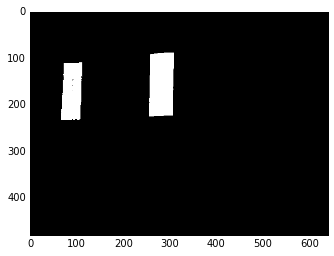

In [19]:
mask = cv2.inRange(hsv, (55, 230, 200), (75, 255, 255))
plt.imshow(mask, 'gray')

## 4. Mask Filtering

There's usually some noise in your image that can make the edges of your mask rough. To make the mask smoother, it's common to apply filters.

Use `cv2.erode` to erode away rough edges and use `cv2.dilate` to grow back the edges once they've been smoothed. Use the `iterations` argument to control how intense the erosion/dilation should be.

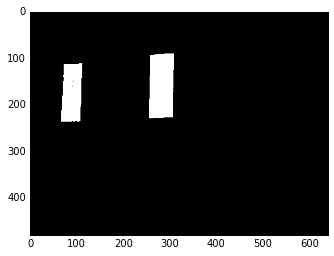

In [20]:
mask = cv2.erode(mask, (5, 5), iterations=2)
mask = cv2.dilate(mask, (5, 5), iterations=4)
plt.imshow(mask, 'gray')

## 5. Finding Contours

`cv2.findContours` does all the heavy lifting for you. If you want to visualize the contours, OpenCV also has a method for doing that: `cv2.drawContours`.

**Important:** some versions of OpenCV return two items from `findContours` and some return three. If your version returns two, the first item is the contours. If your version returns three, the second item is the contours (used below).

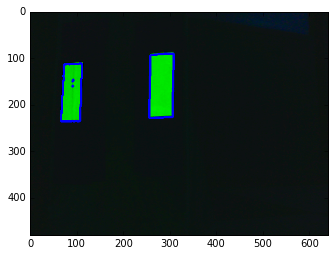

In [33]:
_, contours, _ = cv2.findContours(mask, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)

img_copy = img.copy() # copy image so original isn't overwritten
cv2.drawContours(img_copy, contours, -1, color=(0, 0, 255), thickness=3)
plt.imshow(img_copy)

## 6. Filtering Contours

Even after filtering your mask before finding contours, there will most likely be extraneous contours. As you can see below, there are more than two contours found:

In [22]:
len(contours)

5

However, we only want the two contours that form the outline around the two green shapes. There are a number of ways to filter contours: by inspecting area, contour length, aspect ratio, polygon approximation, and more.

Filtering out contours with very small area is always a good idea. Here are the areas (in pixels) of the 5 detected contours (using `cv2.contourArea`):

In [25]:
[cv2.contourArea(c) for c in contours]

[4.0, 2.0, 4.0, 4864.0, 6756.0]

The contours with areas in the thousands of pixels seem likely to be what we're looking for, so let's filter out the rest using some minimum area threshold:

In [32]:
min_area = 1000
filtered_contours = [c for c in contours if cv2.contourArea(c) > min_area]

len(filtered_contours)

2

We are now left with two contours. Drawing them on the original image confirms that they are the correct contours:

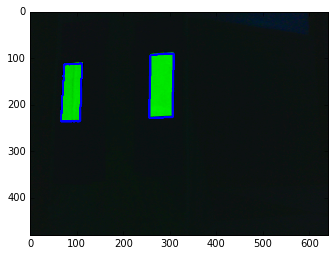

In [34]:
img_copy = img.copy() # copy image so original isn't overwritten
cv2.drawContours(img_copy, filtered_contours, -1, color=(0, 0, 255), thickness=3)
plt.imshow(img_copy)

## 7. Contour post-processing

After you've found good contours around the reflective targets, there are some additional steps that can be performed on them.

### 7b. Finding center of contours

It's often useful to describe the contour's position as a single point. The contour's centroid (center of mass) is a common choice for this point. This code computes and draws the centroid `(cx, cy)` for each filtered contour:

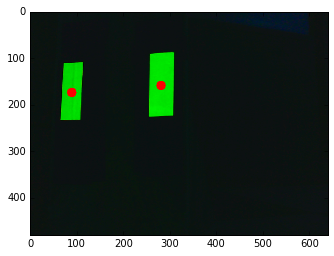

In [39]:
img_copy = img.copy()

for c in filtered_contours:
    M = cv2.moments(c)
    # the center of mass is the first moment divided by the mass
    cx = M["m10"] / M["m00"]
    cy = M["m01"] / M["m00"]
    cx, cy = int(cx), int(cy) # coordinates need to be integers
    
    cv2.circle(img_copy, (cx, cy), 10, (255, 0, 0), thickness=-1)

plt.imshow(img_copy)